In [1]:
import pyicecake

In [2]:
help(pyicecake)

Help on module pyicecake:

NAME
    pyicecake - pybind11 icecake plugin

CLASSES
    pybind11_builtins.pybind11_object(builtins.object)
        GPUCache
    
    class GPUCache(pybind11_builtins.pybind11_object)
     |  Method resolution order:
     |      GPUCache
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(...)
     |      __init__(self: pyicecake.GPUCache, arg0: int) -> None
     |  
     |  get_dltensor(...)
     |      get_dltensor(self: pyicecake.GPUCache, tensor_name: str, deviceID: int) -> capsule
     |      
     |      Get a DLManagedTensor from device memory
     |  
     |  put_dltensor(...)
     |      put_dltensor(self: pyicecake.GPUCache, tensor_name: str, tensor: capsule) -> bool
     |      
     |      Put a DLManagedTensor to device memory
     |  
     |  ----------------------------------------------------------------------
     |  Static methods inherited from pybind11_

In [3]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy 
import cupy 

def edit_images(image1, image2):
    assert image1.shape == image2.shape
    h, w, c = image1.shape
    y, x = cupy.ogrid[0:h, 0:w]
    mask = (x - w / 2) ** 2 + (y - h / 2) ** 2 > h * w / 9
    result1 = cupy.copy(image1)
    result1[mask] = image2[mask]
    result2 = cupy.copy(image2)
    result2[mask] = image1[mask]
    return result1, result2



In [4]:
mix_channels_kernel = cupy.ElementwiseKernel(
        'uint8 x, uint8 y',
        'uint8 z',
        'z = (i % 3) ? x : y',
        'mix_channels'
    )

In [5]:
image_dir = '/home/lwangay/dali-data/images'

class CommonPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super(CommonPipeline, self).__init__(batch_size, num_threads, device_id, exec_async=False,
                                             exec_pipelined=False, seed=99)
        self.input1 = ops.FileReader(file_root=image_dir, random_shuffle=True)
        self.input2 = ops.FileReader(file_root=image_dir, random_shuffle=True)
        self.decode = ops.ImageDecoder(device='mixed', output_type=types.RGB)
        self.resize = ops.Resize(resize_x=300, resize_y=300, device='gpu')
        
    def load(self):
        jpegs1, labels = self.input1()
        jpegs2, labels = self.input2()
        im1, im2 = self.decode([jpegs1, jpegs2])
        return self.resize([im1, im2])
        

class PythonFuncPipeline(CommonPipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super(PythonFuncPipeline, self).__init__(batch_size, num_threads, device_id, image_dir)
        self.edit_images = ops.PythonFunction(function=edit_images, num_outputs=2, device='gpu')
        self.mix = ops.PythonFunction(function=mix_channels_kernel, device='gpu')

    def define_graph(self):
        images1, images2 = self.load()
        res1, res2 = self.edit_images(images1, images2)
        res3 = self.mix(images1, images2)
        return res1, res2, res3

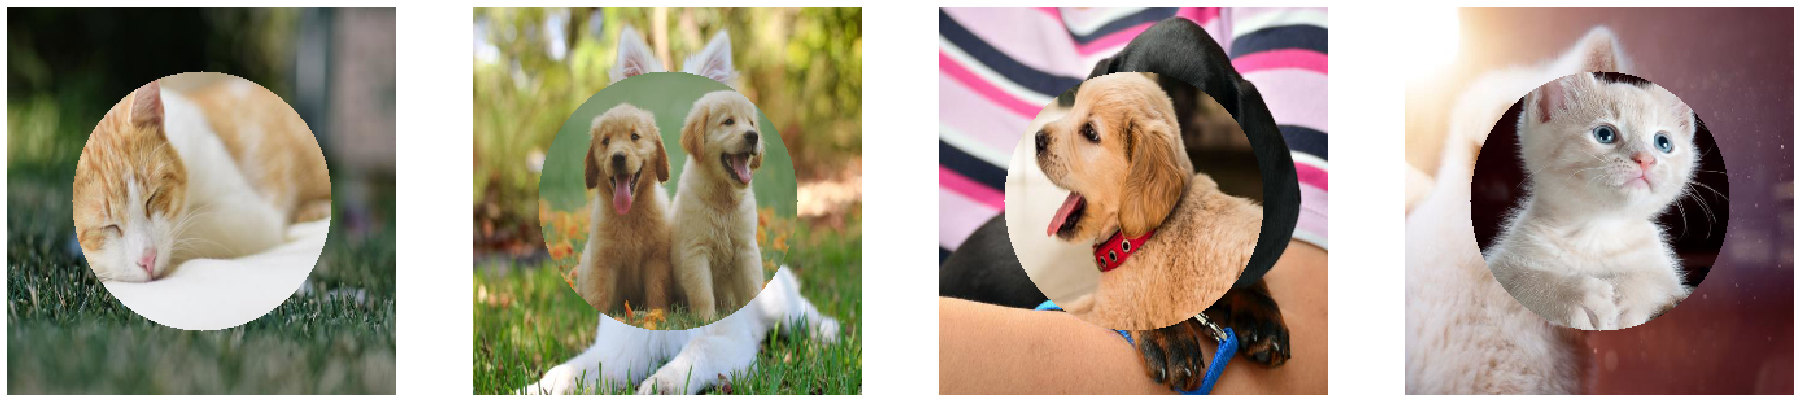

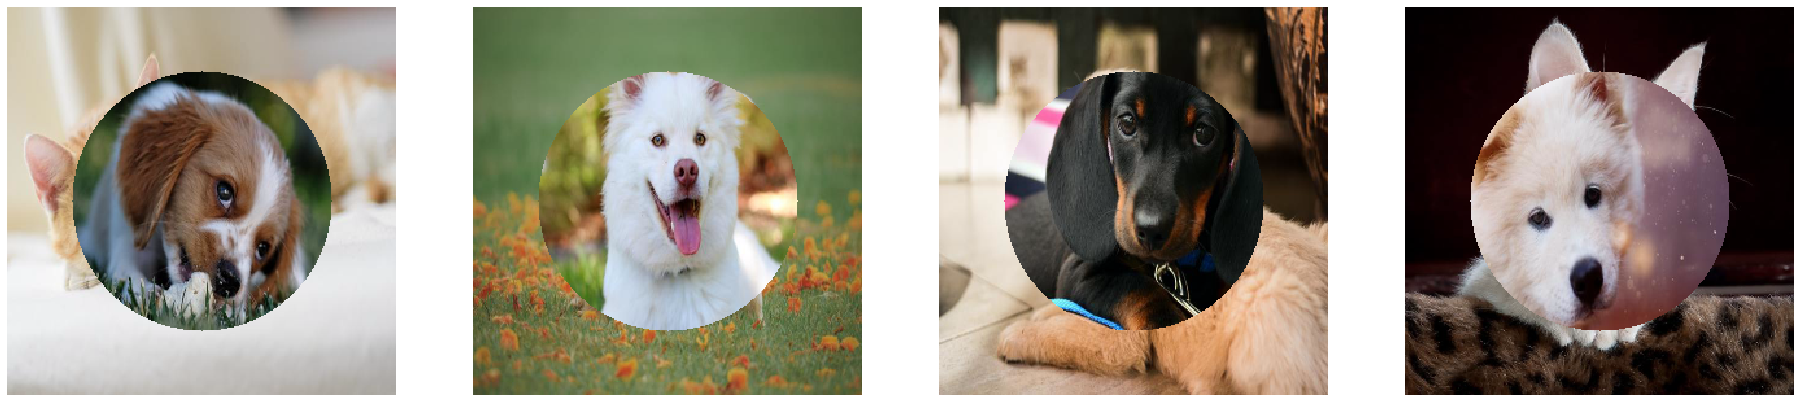

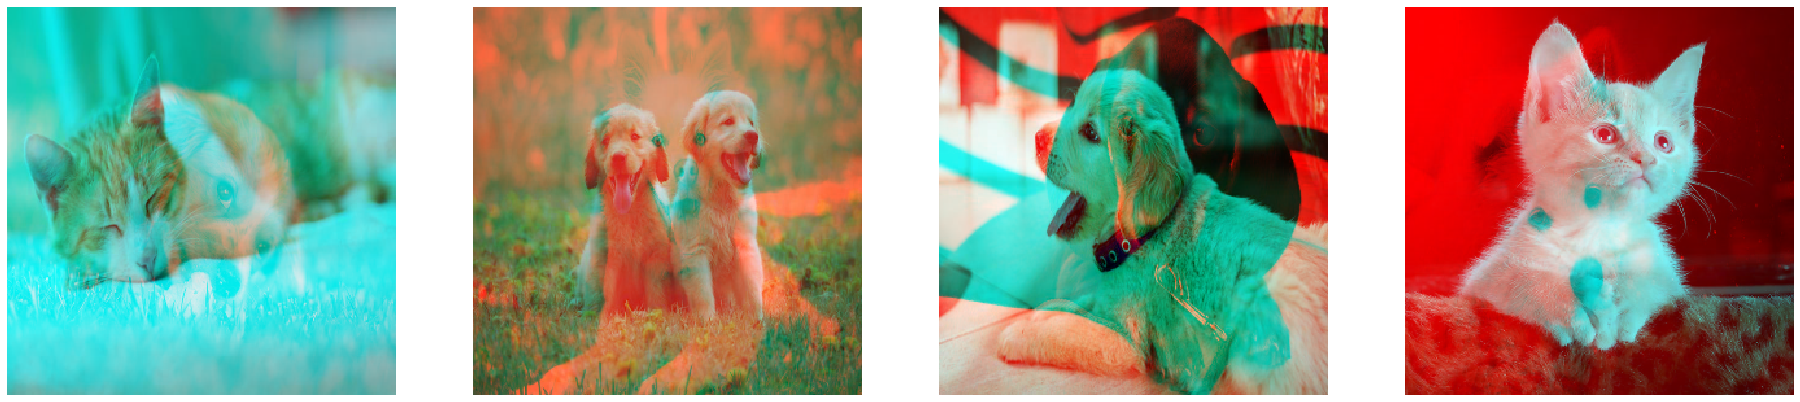

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
%matplotlib inline

batch_size = 4

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))


pipe = PythonFuncPipeline(batch_size, 4, 0, image_dir)
pipe.build()
ims1, ims2, ims3 = pipe.run()

show_images(ims1.as_cpu())
show_images(ims2.as_cpu())
show_images(ims3.as_cpu())

<capsule object "dltensor" at 0x7f9738040e40> <capsule object "dltensor" at 0x7f96d83517b0>
<capsule object "dltensor" at 0x7f96d8351300> <capsule object "dltensor" at 0x7f96d8351810>
<capsule object "dltensor" at 0x7f96d8351330> <capsule object "dltensor" at 0x7f96d8351840>
<capsule object "dltensor" at 0x7f96d8351780> <capsule object "dltensor" at 0x7f96d8351870>


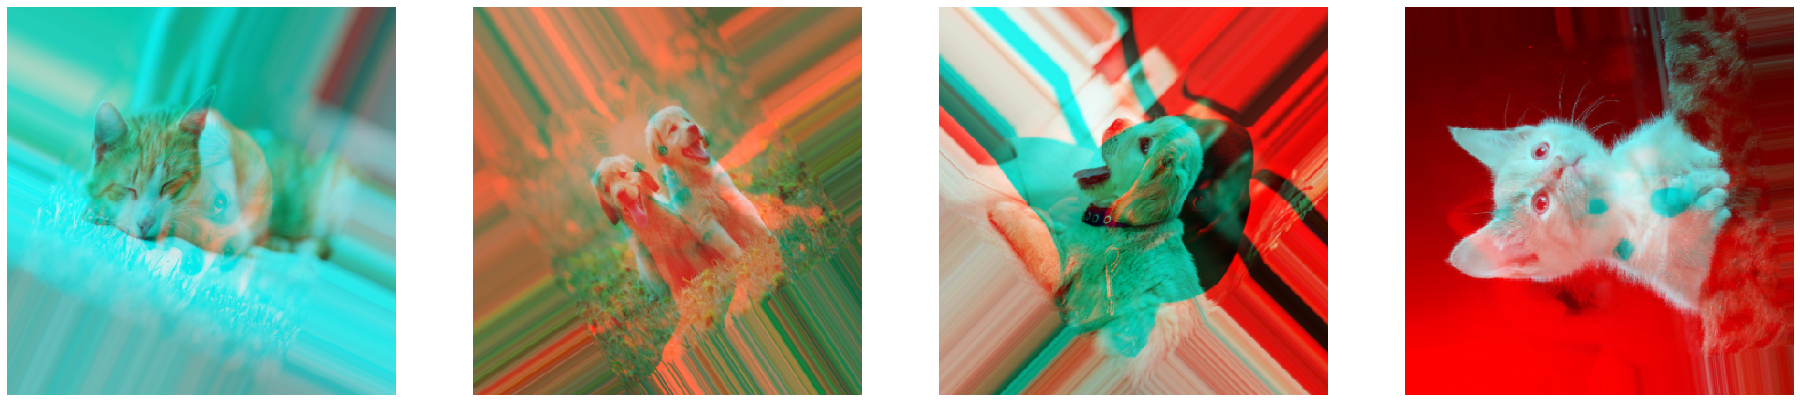

In [7]:
def mix_channels_wrapper(tensor1, tensor2):
    print(tensor1, tensor2)
    array1 = cupy.fromDlpack(tensor1)
    array2 = cupy.fromDlpack(tensor2)
    result = mix_channels_kernel(array1, array2)
    cupy.cuda.get_current_stream().synchronize()
    return result.toDlpack()

class DLTensorPythonFuncPipeline(CommonPipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super(DLTensorPythonFuncPipeline, self).__init__(batch_size, num_threads, device_id, image_dir)
        self.mix = ops.DLTensorPythonFunction(function=mix_channels_wrapper, device='gpu', 
                                              synchronize_stream=True, batch_processing=False)
        self.rotate = ops.Rotate(device='gpu')
        self.rng = ops.Uniform(range = (-100.0, 100.0))

    def define_graph(self):
        images1, images2 = self.load()
        res = self.mix(images1, images2)
        print(res)
        angle = self.rng()
        res = self.rotate(res, angle=angle)
        return res

pipe = DLTensorPythonFuncPipeline(batch_size, 4, 0, image_dir)
pipe.build()
ims, = pipe.run()

show_images(ims.as_cpu())

In [9]:
gc = pyicecake.GPUCache(4*1024*1024*1024) # 4GB

<capsule object "dltensor" at 0x7f96c0562360> <capsule object "dltensor" at 0x7f96d825f2d0>
<capsule object "dltensor" at 0x7f96c0759f60> <capsule object "dltensor" at 0x7f96d825fc90>
<capsule object "dltensor" at 0x7f96d825f720> <capsule object "dltensor" at 0x7f96d825f480>
<capsule object "dltensor" at 0x7f96d825ff90> <capsule object "dltensor" at 0x7f96d825f5a0>


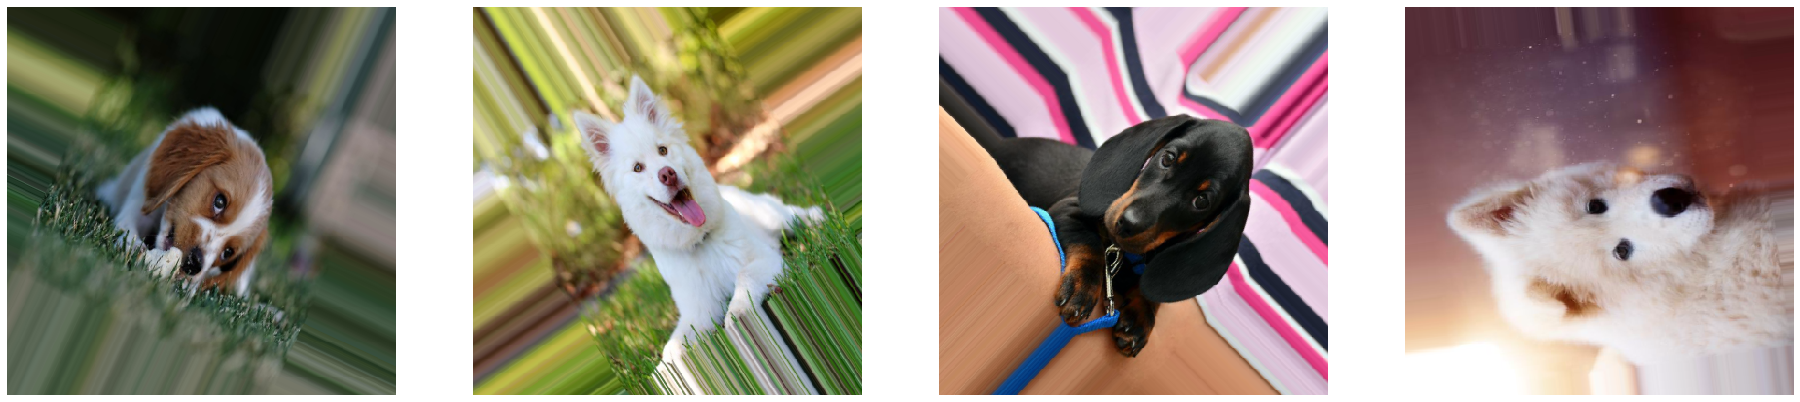

In [16]:
def icecake_wrapper(tensor1, tensor2):
    print(tensor1, tensor2)
    gc.put_dltensor('tensor1', tensor1)
    gc.put_dltensor('tensor2', tensor2)
    array1 = cupy.fromDlpack(gc.get_dltensor('tensor1', 0))
    array2 = cupy.fromDlpack(gc.get_dltensor('tensor2', 0))
    result = mix_channels_kernel(array1, array2)
    cupy.cuda.get_current_stream().synchronize()
#     return result.toDlpack()
    return gc.get_dltensor('tensor2', 0)

class DLTensorPythonFuncPipeline_GC(CommonPipeline):
    def __init__(self, batch_size, num_threads, device_id, image_dir):
        super(DLTensorPythonFuncPipeline_GC, self).__init__(batch_size, num_threads, device_id, image_dir)
        self.mix = ops.DLTensorPythonFunction(function=icecake_wrapper, device='gpu', 
                                              synchronize_stream=True, batch_processing=False)
        self.rotate = ops.Rotate(device='gpu')
        self.rng = ops.Uniform(range = (-100.0, 100.0))

    def define_graph(self):
        images1, images2 = self.load()
        res = self.mix(images1, images2)
        print(res)
        angle = self.rng()
        res = self.rotate(res, angle=angle)
        return res

pipe = DLTensorPythonFuncPipeline_GC(batch_size, 4, 0, image_dir)
pipe.build()
ims, = pipe.run()

show_images(ims.as_cpu())

In [19]:
import nvidia.dali.backend as bd

In [23]:
help(bd.TensorListCPU)

Help on class TensorListCPU in module nvidia.dali.backend_impl:

class TensorListCPU(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      TensorListCPU
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(...)
 |      __getitem__(self: nvidia.dali.backend_impl.TensorListCPU, i: int) -> nvidia.dali.backend_impl.TensorCPU
 |      
 |      
 |      Returns a tensor at given position `i` in the list.
 |      
 |      Parameters
 |      ----------
 |  
 |  __init__(...)
 |      __init__(self: nvidia.dali.backend_impl.TensorListCPU, arg0: buffer, arg1: str) -> None
 |      
 |      
 |      List of tensors residing in the CPU memory.
 |      
 |      Parameters
 |      ----------
 |      b : the buffer to wrap into the TensorListCPU object
 |      layout : the layout description
 |  
 |  __len__(...)
 |      __len__(self: nvidia.dali.backend_impl.TensorListCPU) -> int
 |  
 |  as_array(...)
 |      as_array(s